*All libraries used*

In [1]:
import requests
import time
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt

import sys
!{sys.executable} -m spacy download en_core_web_sm
from pprint import pprint

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','https','co','amp','ba','airasiasupport','delta','americanair','southwestair','british_airways','dm','swa','southwest','1hr'])

#Import Regular Expression
import regex as re

import warnings
warnings.filterwarnings('ignore')

#sns.set(style='whitegrid', palette='muted')
sns.set(palette='muted')
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 0

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


C:\Users\PQKoh\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


## 1 Data Import and Cleaning

Using a clean the dataset that has been processed during the Multiclass Classfication stage.

In [2]:
#Reading combine 5 airlines dataset
combine_airlines_df = pd.read_csv("../dataset/combine_airlines.csv")

In [3]:
combine_airlines_df.head(10)

,Unnamed: 0,text_x,label,text_y,text_x+y
0,0,"@693931 large recon with xl vertex, under window seat on @southwestair https://t.co/pfqxtice15",4,"@693930 glad to know it fits, eric. thank you for your service! ^ng","@693931 large recon with xl vertex, under window seat on @southwestair https://t.co/pfqxtice15@693930 glad to know it fits, eric. thank you for your service! ^ng"
1,1,waiting on our clients arrival heathrow_airport with @british_airways #mercedes #chauffeur… https://t.co/lqgo0tvvgv,2,@303145 we're sorry there was a delay and hope you're all on your way now. ^julie,waiting on our clients arrival heathrow_airport with @british_airways #mercedes #chauffeur… https://t.co/lqgo0tvvgv@303145 we're sorry there was a delay and hope you're all on your way now. ^julie
2,2,@delta you are killing me with the forever delayed flight..#somuchforstatus,3,@333579 hi kevin. i am so sorry for the delayed flight. please follow/dm your confirmation code or tkt # to learn more. *tkr,@delta you are killing me with the forever delayed flight..#somuchforstatus@333579 hi kevin. i am so sorry for the delayed flight. please follow/dm your confirmation code or tkt # to learn more. *tkr
3,3,@airasiasupport\n\nhow do i sign up for bigpay?,0,"@524583 hi soon, you just have to visit at https://t.co/vzlne0hmou to save your card detail for bigpay. cheers! :d -amie","@airasiasupport\n\nhow do i sign up for bigpay?@524583 hi soon, you just have to visit at https://t.co/vzlne0hmou to save your card detail for bigpay. cheers! :d -amie"
4,4,"@british_airways 'we'll update you by 1600 hours' it's 16.07, no update and 100s still in the dark.. you are making a pigs ear out of this ! https://t.co/muhbphcfsr",2,@604068 we're sorry our website wasn't updated at exactly 16:00. we can see that a further update will be posted at approximately 18:00 bst. ^steph,"@british_airways 'we'll update you by 1600 hours' it's 16.07, no update and 100s still in the dark.. you are making a pigs ear out of this ! https://t.co/muhbphcfsr@604068 we're sorry our website wasn't updated at exactly 16:00. we can see that a further update will be posted at approximately 18:00 bst. ^steph"
5,5,"hey @delta, our flight #dl3409 was diverted &amp; donna at gate 5 stewart ny was amazing to everyone. she deserves recognition #aboveandbeyond",3,"@759947 hi lindsay, thanks for recognizing our donna. we appreciate your patience and courtesy. *tmb","hey @delta, our flight #dl3409 was diverted &amp; donna at gate 5 stewart ny was amazing to everyone. she deserves recognition #aboveandbeyond@759947 hi lindsay, thanks for recognizing our donna. we appreciate your patience and courtesy. *tmb"
6,6,@delta is your website and app down right now? https://t.co/ld2ckr9puz,3,@305638 thank you for your patience. *ala,@delta is your website and app down right now? https://t.co/ld2ckr9puz@305638 thank you for your patience. *ala
7,7,amanece en aeropuerto de ezeiza b777 de @americanair en posicion 2 plataforma principal. https://t.co/mv2r6zxwmb,1,@387640 that's a gorgeous #americanview marcelo! we'll take you off into the sunrise any day.,amanece en aeropuerto de ezeiza b777 de @americanair en posicion 2 plataforma principal. https://t.co/mv2r6zxwmb@387640 that's a gorgeous #americanview marcelo! we'll take you off into the sunrise any day.
8,8,"@delta so why send me an email asking me to register to win a london trip with chelsea fc tix, but then tell me i'm not eligible to enter?",3,"@616141 hi whitney, my apologies for any inconvenience. our marketing team is looking into this reported issue and working to resolve it. *hrs","@delta so why send me an email asking me to register to win a london trip with chelsea fc tix, but then tell me i'm not eligible to enter?@616141 hi whitney, my apologies for any inconvenience. our marketing team is looking into this reported issue and working to resolve it. *hrs"
9,9,"@231644 need ur help!! want a name change on my flight with @british_airways but they won't do it, bin 

Only column "text_x+y" which is both the inbound and outbound message will be process for topic modelling.

In [4]:
#Dropped unwanted columns
combine_airlines_df.drop(columns = ['Unnamed: 0'], inplace=True)
combine_airlines_df.head(10)

,text_x,label,text_y,text_x+y
0,"@693931 large recon with xl vertex, under window seat on @southwestair https://t.co/pfqxtice15",4,"@693930 glad to know it fits, eric. thank you for your service! ^ng","@693931 large recon with xl vertex, under window seat on @southwestair https://t.co/pfqxtice15@693930 glad to know it fits, eric. thank you for your service! ^ng"
1,waiting on our clients arrival heathrow_airport with @british_airways #mercedes #chauffeur… https://t.co/lqgo0tvvgv,2,@303145 we're sorry there was a delay and hope you're all on your way now. ^julie,waiting on our clients arrival heathrow_airport with @british_airways #mercedes #chauffeur… https://t.co/lqgo0tvvgv@303145 we're sorry there was a delay and hope you're all on your way now. ^julie
2,@delta you are killing me with the forever delayed flight..#somuchforstatus,3,@333579 hi kevin. i am so sorry for the delayed flight. please follow/dm your confirmation code or tkt # to learn more. *tkr,@delta you are killing me with the forever delayed flight..#somuchforstatus@333579 hi kevin. i am so sorry for the delayed flight. please follow/dm your confirmation code or tkt # to learn more. *tkr
3,@airasiasupport\n\nhow do i sign up for bigpay?,0,"@524583 hi soon, you just have to visit at https://t.co/vzlne0hmou to save your card detail for bigpay. cheers! :d -amie","@airasiasupport\n\nhow do i sign up for bigpay?@524583 hi soon, you just have to visit at https://t.co/vzlne0hmou to save your card detail for bigpay. cheers! :d -amie"
4,"@british_airways 'we'll update you by 1600 hours' it's 16.07, no update and 100s still in the dark.. you are making a pigs ear out of this ! https://t.co/muhbphcfsr",2,@604068 we're sorry our website wasn't updated at exactly 16:00. we can see that a further update will be posted at approximately 18:00 bst. ^steph,"@british_airways 'we'll update you by 1600 hours' it's 16.07, no update and 100s still in the dark.. you are making a pigs ear out of this ! https://t.co/muhbphcfsr@604068 we're sorry our website wasn't updated at exactly 16:00. we can see that a further update will be posted at approximately 18:00 bst. ^steph"
5,"hey @delta, our flight #dl3409 was diverted &amp; donna at gate 5 stewart ny was amazing to everyone. she deserves recognition #aboveandbeyond",3,"@759947 hi lindsay, thanks for recognizing our donna. we appreciate your patience and courtesy. *tmb","hey @delta, our flight #dl3409 was diverted &amp; donna at gate 5 stewart ny was amazing to everyone. she deserves recognition #aboveandbeyond@759947 hi lindsay, thanks for recognizing our donna. we appreciate your patience and courtesy. *tmb"
6,@delta is your website and app down right now? https://t.co/ld2ckr9puz,3,@305638 thank you for your patience. *ala,@delta is your website and app down right now? https://t.co/ld2ckr9puz@305638 thank you for your patience. *ala
7,amanece en aeropuerto de ezeiza b777 de @americanair en posicion 2 plataforma principal. https://t.co/mv2r6zxwmb,1,@387640 that's a gorgeous #americanview marcelo! we'll take you off into the sunrise any day.,amanece en aeropuerto de ezeiza b777 de @americanair en posicion 2 plataforma principal. https://t.co/mv2r6zxwmb@387640 that's a gorgeous #americanview marcelo! we'll take you off into the sunrise any day.
8,"@delta so why send me an email asking me to register to win a london trip with chelsea fc tix, but then tell me i'm not eligible to enter?",3,"@616141 hi whitney, my apologies for any inconvenience. our marketing team is looking into this reported issue and working to resolve it. *hrs","@delta so why send me an email asking me to register to win a london trip with chelsea fc tix, but then tell me i'm not eligible to enter?@616141 hi whitney, my apologies for any inconvenience. our marketing team is looking into this reported issue and working to resolve it. *hrs"
9,"@231644 need ur help!! want a name change on my flight with @british_airways but they won't do it, bin told i have to buy another flig

In [5]:
#Convert 'text_x+y' columns to string.
combine_airlines_df['text_x+y'] = combine_airlines_df['text_x+y'].astype(str)

In [6]:
combine_airlines_df.shape

(100642, 4)

## 2 Pre-Processing

### 2.1 Tokenizing/Regularization

In [7]:
# Convert to list
data = combine_airlines_df['text_x+y'].values.tolist()

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) #Convert into a list of lowercase tokens, Remove accent marks from tokens
        yield(sent)  

data_words = list(sent_to_words(data))


In [9]:
print(data_words[:2])

[['large', 'recon', 'with', 'xl', 'vertex', 'under', 'window', 'seat', 'on', 'glad', 'to', 'know', 'it', 'fits', 'eric', 'thank', 'you', 'for', 'your', 'service', 'ng'], ['waiting', 'on', 'our', 'clients', 'arrival', 'with', 'mercedes', 'chauffeur', 'were', 'sorry', 'there', 'was', 'delay', 'and', 'hope', 'youre', 'all', 'on', 'your', 'way', 'now', 'julie']]


### 2.2 Build bigram and trigram models

When using BOW model, it is essential to build bi-gram and tri-gram from sentences.

In [10]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### 2.3 Stopwords/Bigram/Trigram/Lemmatization

In [11]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
#!python -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts] # Remove Stopwords
    texts = [bigram_mod[doc] for doc in texts] # Form Bigrams
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts] # Form Trigrams
    texts_out = []
    # Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data

In [12]:
data_ready

[['large',
  'recon',
  'vertex',
  'window',
  'seat',
  'glad',
  'know',
  'fit',
  'eric',
  'thank',
  'service'],
 ['wait',
  'client',
  'arrival',
  'mercede',
  'chauffeur',
  'sorry',
  'delay',
  'hope',
  'way',
  'julie'],
 ['kill',
  'forever',
  'delay',
  'sorry',
  'delayed',
  'flight',
  'follow',
  'confirmation',
  'code',
  'tkt',
  'learn',
  'tkr'],
 ['sign',
  'soon',
  'visit',
  'vzlne',
  'hmou',
  'save',
  'card',
  'detail',
  'bigpay',
  'cheers_amie'],
 ['update',
  'hour',
  'update',
  'still',
  'dark',
  'make',
  'pig',
  'ear',
  'sorry',
  'website',
  'update',
  'exactly',
  'see',
  'update',
  'post',
  'approximately',
  'bst',
  'steph'],
 ['flight',
  'dl',
  'divert',
  'donna',
  'gate',
  'stewart',
  'ny',
  'amazing',
  'everyone',
  'deserve',
  'recognition',
  'lindsay',
  'thank',
  'recognize',
  'donna',
  'appreciate',
  'patience',
  'courtesy',
  'tmb'],
 ['website', 'app', 'right', 'thank', 'patience', 'ala'],
 ['amanece',
 

## 3 LDA model

### 3.1 Inputs (Dictionary, Corpus)

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [14]:
# View corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[('eric', 1),
  ('fit', 1),
  ('glad', 1),
  ('know', 1),
  ('large', 1),
  ('recon', 1),
  ('seat', 1),
  ('service', 1),
  ('thank', 1),
  ('vertex', 1),
  ('window', 1)],
 [('arrival', 1),
  ('chauffeur', 1),
  ('client', 1),
  ('delay', 1),
  ('hope', 1),
  ('julie', 1),
  ('mercede', 1),
  ('sorry', 1),
  ('wait', 1),
  ('way', 1)],
 [('delay', 1),
  ('sorry', 1),
  ('code', 1),
  ('confirmation', 1),
  ('delayed', 1),
  ('flight', 1),
  ('follow', 1),
  ('forever', 1),
  ('kill', 1),
  ('learn', 1),
  ('tkr', 1),
  ('tkt', 1)]]

### 3.2 Coherence score

In [15]:
# Compute coherence score for various number of topics 
#https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
#https://www.machinelearningplus.com/nlp/gensim-tutorial/

chunksize=2500
passes=20
alpha='symmetric'
iterations=200

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              id2word=dictionary, 
                                              num_topics=num_topics,
                                              alpha=alpha,
                                              chunksize=chunksize,
                                              random_state=100,
                                              update_every=1,
                                              passes=passes,
                                              iterations=iterations,
                                              per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Looping through from 2 topics to 8 topics.

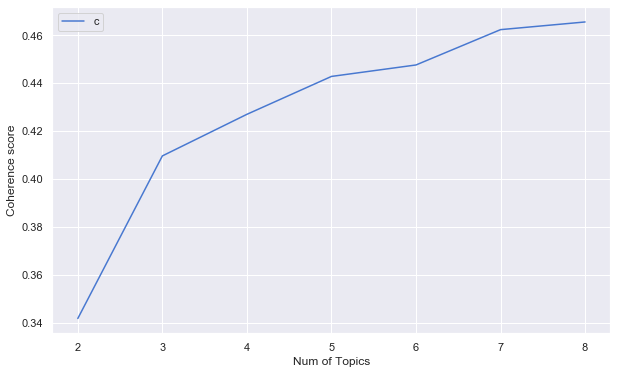

In [16]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=9, step=1)
# Show graph
limit=9; start=2; step=1;
x = range(start, limit, step)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x, coherence_values)
plt.xlabel("Num of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
"Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference."

From the above plot, the score increase when the number of topics increase. Repeated keywords may appear across different topics if we were to choose a higher number topics with a higher coherence score. Will be doing for 5 topics. However, a pyLDAvis plot for both 5 and 6 will be done to see the topics distribution.

### 3.3 Train

Training the model using 5 topics. 

In [17]:
chunksize=2500
passes=20
alpha='symmetric'
iterations=200

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           per_word_topics=True)

In [18]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.442890957417129


### 3.4 Visualize the topics-keywords

#### 3.4.1 pyLDAvis for 5 topics

In [19]:
# Visualize the topics

#chunksize=2500
#passes=20
#alpha='symmetric'
#iterations=200
#topic = 5 

pyLDAvis.enable_notebook()
vis= pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.168477 -0.107137  1       1        26.649502
2     -0.037290 -0.151597  2       1        22.999588
0     -0.203303 -0.092444  3       1        21.158012
1      0.209642  0.120688  4       1        15.260583
4     -0.137526  0.230490  5       1        13.932315, topic_info=     Category          Freq          Term         Total  loglift  logprob
8     Default  29548.000000  thank         29548.000000  30.0000  30.0000
6     Default  10144.000000  seat          10144.000000  29.0000  29.0000
14    Default  13475.000000  delay         13475.000000  28.0000  28.0000
7     Default  9191.000000   service       9191.000000   27.0000  27.0000
215   Default  8392.000000   customer      8392.000000   26.0000  26.0000
364   Default  7558.000000   bag           7558.000000   25.0000  25.0000
170   Default  14708.000000  check         14708.000000  24.0000  24.0000
141   Default  9545.000000   great         9545.000000   23.0000  23.0000
391   Default  8022.000000   book          8022.000000   22.0000  22.0000
24    Default  51867.000000  flight        51867.000000  21.0000  21.0000
280   Default  13232.000000  number        13232.000000  20.0000  20.0000
354   Default  6735.000000   booking       6735.000000   19.0000  19.0000
22    Default  6835.000000   confirmation  6835.000000   18.0000  18.0000
232   Default  5847.000000   experience    5847.000000   17.0000  17.0000
244   Default  7037.000000   love          7037.000000   16.0000  16.0000
46    Default  7757.000000   hour          7757.000000   15.0000  15.0000
463   Default  4545.000000   baggage       4545.000000   14.0000  14.0000
122   Default  7652.000000   board         7652.000000   13.0000  13.0000
88    Default  4947.000000   email         4947.000000   12.0000  12.0000
18    Default  16662.000000  sorry         16662.000000  11.0000  11.0000
355   Default  4048.000000   contact       4048.000000   10.0000  10.0000
187   Default  4565.000000   enjoy         4565.000000   9.0000   9.0000 
216   Default  10244.000000  hear          10244.000000  8.0000   8.0000 
38    Default  5720.000000   soon          5720.000000   7.0000   7.0000 
193   Default  3577.000000   upgrade       3577.000000   6.0000   6.0000 
2     Default  5126.000000   glad          5126.000000   5.0000   5.0000 
19    Default  6616.000000   wait          6616.000000   4.0000   4.0000 
173   Default  21870.000000  get           21870.000000  3.0000   3.0000 
372   Default  3689.000000   miss          3689.000000   2.0000   2.0000 
108   Default  8259.000000   change        8259.000000   1.0000   1.0000 
...       ...          ...      ...                ...      ...      ... 
193   Topic5   2940.597412   upgrade       3577.769775   1.7748  -4.3854 
1227  Topic5   722.573242    office        788.652222    1.8835  -5.7889 
478   Topic5   1681.153687   allow         2248.354492   1.6802  -4.9445 
170   Topic5   7277.105957   check         14708.886719  1.2672  -3.4793 
595   Topic5   2341.927490   pay           3645.352539   1.5285  -4.6130 
122   Topic5   3993.937744   board         7652.351074   1.3207  -4.0792 
716   Topic5   1040.400757   open          1412.904175   1.6649  -5.4244 
394   Topic5   1333.102905   charge        2034.579224   1.5482  -5.1765 
273   Topic5   1715.070923   find          3443.821777   1.2738  -4.9246 
985   Topic5   1055.780518   extra         1729.843018   1.4772  -5.4097 
3102  Topic5   781.494568    policy        1042.196411   1.6831  -5.7106 
214   Topic5   2106.371338   airport       6086.569336   0.9098  -4.7190 
392   Topic5   972.089661    bring         1539.512451   1.5112  -5.4923 
167   Topic5   1100.335938   available     2051.633301   1.3479  -5.3684 
589   Topic5   1041.935669   class         2014.516846   1.3117  -5.4229 
360   Topic5   980.145569    purchase      1850.810059   1.3353  -5.4841 
276   Topic5   1200.454102 

#### 3.4.2 pyLDAvis for 6 topics

In [20]:
chunksize=2500
passes=20
alpha='symmetric'
iterations=200

lda_model_6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           per_word_topics=True)

vis_6 = pyLDAvis.gensim.prepare(lda_model_6, corpus, dictionary=lda_model_6.id2word)
vis_6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.115756  0.215679  1       1        24.938566
1      0.060670  0.163044  2       1        22.566048
0      0.069745 -0.224957  3       1        15.737928
5     -0.075457 -0.114674  4       1        13.593863
2      0.155797 -0.084148  5       1        13.565005
4     -0.326511  0.045056  6       1        9.598584 , topic_info=     Category          Freq          Term         Total  loglift  logprob
8     Default  29557.000000  thank         29557.000000  30.0000  30.0000
14    Default  13611.000000  delay         13611.000000  29.0000  29.0000
364   Default  7729.000000   bag           7729.000000   28.0000  28.0000
280   Default  13242.000000  number        13242.000000  27.0000  27.0000
170   Default  14866.000000  check         14866.000000  26.0000  26.0000
6     Default  10240.000000  seat          10240.000000  25.0000  25.0000
114   Default  12954.000000  help          12954.000000  24.0000  24.0000
22    Default  6825.000000   confirmation  6825.000000   23.0000  23.0000
141   Default  9533.000000   great         9533.000000   22.0000  22.0000
63    Default  5484.000000   gate          5484.000000   21.0000  21.0000
354   Default  6779.000000   booking       6779.000000   20.0000  20.0000
215   Default  8305.000000   customer      8305.000000   19.0000  19.0000
463   Default  4648.000000   baggage       4648.000000   18.0000  18.0000
93    Default  10910.000000  look          10910.000000  17.0000  17.0000
391   Default  8070.000000   book          8070.000000   16.0000  16.0000
244   Default  7028.000000   love          7028.000000   15.0000  15.0000
88    Default  4979.000000   email         4979.000000   14.0000  14.0000
18    Default  16736.000000  sorry         16736.000000  13.0000  13.0000
7     Default  9069.000000   service       9069.000000   12.0000  12.0000
108   Default  8303.000000   change        8303.000000   11.0000  11.0000
355   Default  4075.000000   contact       4075.000000   10.0000  10.0000
129   Default  6732.000000   happy         6732.000000   9.0000   9.0000 
446   Default  6231.000000   try           6231.000000   8.0000   8.0000 
696   Default  3533.000000   idgbjac       3533.000000   7.0000   7.0000 
25    Default  3943.000000   follow        3943.000000   6.0000   6.0000 
118   Default  9783.000000   need          9783.000000   5.0000   5.0000 
187   Default  4559.000000   enjoy         4559.000000   4.0000   4.0000 
24    Default  52117.000000  flight        52117.000000  3.0000   3.0000 
903   Default  2587.000000   luggage       2587.000000   2.0000   2.0000 
193   Default  3593.000000   upgrade       3593.000000   1.0000   1.0000 
...       ...          ...       ...               ...      ...      ... 
1144  Topic6   459.949463    reunite       460.781860    2.3417  -5.8681 
390   Topic6   426.614746    attention     427.449554    2.3416  -5.9433 
1529  Topic6   417.915833    economy       418.751068    2.3416  -5.9639 
1     Topic6   412.116364    fit           412.949249    2.3415  -5.9779 
495   Topic6   394.210022    phl           395.045929    2.3414  -6.0223 
2110  Topic6   378.822815    suitcase      379.655365    2.3414  -6.0621 
1231  Topic6   364.831207    force         365.665161    2.3413  -6.0998 
2120  Topic6   339.707123    file_claim    340.538361    2.3411  -6.1711 
328   Topic6   339.507385    aisle         340.341980    2.3411  -6.1717 
1227  Topic6   694.895142    office        804.692871    2.1969  -5.4554 
166   Topic6   2312.777588   agent         3597.691650   1.9017  -4.2530 
392   Topic6   1142.190063   bring         1561.970825   2.0306  -4.9585 
1875  Topic6   563.348389    working_hard  650.503418    2.1997  -5.6653 
274   Topic6   727.664917    hand          936.917114    2.0908  -5.4094 
170   Topic6   3969.696045   check         14866.257812  1.0232  -3.7128 
276   Topic6   1355.591919   leave         3179

-In pyLDAvis for 5 topics: The bubbles are fairly big without any overlapping.

-In pyLDAvis for 6 topics: There are two bubbles that are overlapped.

Good topic modelling will have bubbles that are fairly big, scattered throughout the chart and also not over-lapping.

### 3.5 Determine Dominant Topic

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list   # .per_word_topics list down the % of each topic
        row_sort = sorted(row, key=lambda x: (x[1]), reverse=True)  
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, dominant_perc) in enumerate(row_sort): 
            if j == 0:  # => dominant topic
                row = np.around(row,2)
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([topic_num, round(dominant_perc,2),row, topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant Topic', 'Dominant %', 'Individual Topic %', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [22]:
text_list= combine_airlines_df['text_x'].tolist()
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_list)

In [23]:
#chunksize=2500
#passes=20
#alpha='symmetric'
#iterations=200

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Doc. No.', 'Dominant Topic','Dominant %','Individual Topic % ', 'Topic Keywords', 'Document Text']
df_dominant_topic.tail(50)

,Doc. No.,Dominant Topic,Dominant %,Individual Topic %,Topic Keywords,Document Text
100592,100592,3.0,0.62,"[[0.0, 0.08], [1.0, 0.13], [2.0, 0.17], [3.0, 0.62]]","thank, flight, great, fly, love, get, hope, see, good, soon",s/o to anne @americanair for waiving last minute fees so i can get to see a family member in emergency medical situation #customerservice
100593,100593,3.0,0.87,"[[1.0, 0.06], [3.0, 0.87], [4.0, 0.06]]","thank, flight, great, fly, love, get, hope, see, good, soon","fields of cotton from 39,000 feet! #cloudporn #skyhigh #windowseat #airplaneview #happythanksgiving2017 #airplaneseat #sunshine #clouds #southwestairlines #vacation #vacationtravel @southwestair https://t.co/lksygbkcfv"
100594,100594,0.0,0.54,"[[0.0, 0.54], [1.0, 0.15], [2.0, 0.16], [3.0, 0.01], [4.0, 0.14]]","flight, book, thank, booking, number, check, change, email, help, contact",@british_airways disappointed in ba. no response to email of 11/10 to customer support following a bereavement and emergency flight home.
100595,100595,0.0,0.86,"[[0.0, 0.86], [1.0, 0.01], [2.0, 0.1], [3.0, 0.01], [4.0, 0.01]]","flight, book, thank, booking, number, check, change, email, help, contact",@british_airways i have booked a flight for someone in another country. do they need to have my credit card when checking in?
100596,100596,3.0,0.77,"[[0.0, 0.18], [1.0, 0.02], [2.0, 0.02], [3.0, 0.77], [4.0, 0.02]]","thank, flight, great, fly, love, get, hope, see, good, soon",flying home with @british_airways on ba0012 after an amazing holiday!
100597,100597,4.0,0.44,"[[0.0, 0.08], [1.0, 0.22], [2.0, 0.24], [3.0, 0.01], [4.0, 0.44]]","seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay","hey @southwestair i paid for biz select to board early and get out early. your agent ""volunteered"" me for carry check in. refund please? :("
100598,100598,3.0,0.82,"[[0.0, 0.01], [1.0, 0.08], [2.0, 0.08], [3.0, 0.82], [4.0, 0.01]]","thank, flight, great, fly, love, get, hope, see, good, soon",#macysdayparade\n\nthe most beautiful thing on this parade\n@140153 @delta employee singing tree\nthat is who we are #america\n#happythanksgivingday \nand looking forward to a great #christmas
100599,100599,1.0,0.48,"[[1.0, 0.48], [2.0, 0.32], [4.0, 0.18]]","service, customer, experience, hear, sorry, team, know, fly, bad, feedback",he could remove the entire panel and the passengers would totally be okay with it. @americanair missed flight over no monitor? easy choice.
100600,100600,3.0,0.92,"[[0.0, 0.02], [1.0, 0.02], [2.0, 0.02], [3.0, 0.92], [4.0, 0.02]]","thank, flight, great, fly, love, get, hope, see, good, soon",always love flying @southwestair ✈️✈️ #ontheroadagain https://t.co/jeaxfcqip4
100601,100601,3.0,0.93,"[[0.0, 0.02], [1.0, 0.02], [2.0, 0.02], [3.0, 0.93], [4.0, 0.02]]","thank, flight, great, fly, love, get, hope, see, good, soon",couples who drink coffee together stay together ☕️✈️💯 thanks again @delta for being the best!! #coffeefilledsunshine https://t.co/myrsvvind7 https://t.co/l2uvuznykb


#### 3.5.1 Topic 0

In [25]:
topic0_df = df_dominant_topic[(df_dominant_topic['Dominant %'] >=0.9) & (df_dominant_topic['Dominant Topic'] == 0.0)].sort_values(by = 'Dominant %')
topic0_df.drop(columns = 'Individual Topic % ', inplace = True)
topic0_df.head(50)

,Doc. No.,Dominant Topic,Dominant %,Topic Keywords,Document Text
51486,51486,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact","@british_airways hi, can you please dm me"
27740,27740,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact",@airasiasupport can i purchase baggage'fee by phone call or xxx? why does nobody anwser me?
82637,82637,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact",@airasiasupport hi can you check my booking number ?..
82641,82641,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact","@airasiasupport hi, i made a booking reference aszupr but i can't find confirmation either in manage my booking or online - has the booking been made and paid for?"
83117,83117,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact","@airasiasupport halo admin, dimana saya bisa tau mengenai promo2 tiket dr airasia ? trims"
26575,26575,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact",@airasiasupport จ่ายเงินเคาว์เตอร์เซอวิสแล้ว แต่ไม่ได้ข้อความยืนยันในอีเมลล์ ต้องใช้ส่งให้เพื่อนดู
26574,26574,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact",@airasiasupport 予約時にパスポートナンバーは必要ないですか？
26534,26534,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact",correct gender and name: mr. muhammad nur azmi. birthday: 12 dec 2012. booking number: unrrtg. with report number 00423265 @airasiasupport
83615,83615,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact","@british_airways hello, i need assistance with my booking"
83808,83808,0.0,0.91,"flight, book, thank, booking, number, check, change, email, help, contact",@airasiasupport hi could you please reply my dm? thanks


As can been seen from the Topic Keywords and Document Text, words such as "flight, "booking", "check", "number" and "refund" shows passengers queries on their flight booking or flight refund.

So, Topic 0 can be "Filght Query (Booking/Refund)".

#### 3.5.2 Topic 1

In [26]:
topic1_df = df_dominant_topic[(df_dominant_topic['Dominant %'] >=0.9) & (df_dominant_topic['Dominant Topic'] == 1.0)].sort_values(by = 'Dominant %')
topic1_df.drop(columns = 'Individual Topic % ', inplace = True)
topic1_df.head(50)

,Doc. No.,Dominant Topic,Dominant %,Topic Keywords,Document Text
1365,1365,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",@southwestair is horrible when it comes to military!
85251,85251,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback","i hate @americanair! i hate them, i hate them, i hate them! 😡😡😡😡😡😡😡😡"
16744,16744,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",never flying @americanair again
81755,81755,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",@153717 #ballsup now blaming @british_airways !?! one time it's not justified!!!
18407,18407,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback","hey @delta , wow you guys suck."
79454,79454,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",i promise i will never fly @americanair again.
74680,74680,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",@southwestair i really dislike you after my last flight.
74643,74643,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",kiara at gate b3 in baltimore is the rudest airline employee i've ever experienced. i thought your employees were supposed to have top notch customer service!? not friendly or helpful @southwestair
87172,87172,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",@british_airways am flying from t4 with air malta but am ba silver card holder. which lounge can i use?
22171,22171,1.0,0.91,"service, customer, experience, hear, sorry, team, know, fly, bad, feedback",@delta customer service is the worst in the business period!! https://t.co/5n0k1glyou


As can been seen from the Topic Keywords and Document Text, negative words such as "bad, "sorry", "horrible", "worst" and "terrible" shows the passengers are not very happy with the airline. 

So, Topic 1 can be "Passengers' Bad Experience".


#### 3.5.3 Topic 2

In [27]:
topic2_df = df_dominant_topic[(df_dominant_topic['Dominant %'] >=0.9) & (df_dominant_topic['Dominant Topic'] == 2.0)].sort_values(by = 'Dominant %')
topic2_df.drop(columns = 'Individual Topic % ', inplace = True)
topic2_df.head(50)

,Doc. No.,Dominant Topic,Dominant %,Topic Keywords,Document Text
37847,37847,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",why is it that every @delta flight i have is delayed?????????????????
12203,12203,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",@delta how do i cancel a reservation from the app?
56047,56047,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",turns out the @delta flight is a legit maintenance issue. strange that they said they “need” the plane tho
55499,55499,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",@british_airways why has flight ba0604 to psr been cancelled?
11809,11809,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look","@southwestair , i ❤️ you but we are so over flight 5048."
77313,77313,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",@americanair how do i cancel standby? going to stay on my original flight
77747,77747,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",@delta - can i link res gk69mi and g62xn3 for the flight from jfk to lax?
77827,77827,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",hi @delta - i think i left something on a plane. who can i call to confirm?
77887,77887,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look","@delta i sent you a dm for help, did you get it?"
55146,55146,2.0,0.91,"flight, delay, get, sorry, hour, confirmation, number, help, time, look",@americanair is trying to kill me.


As can been seen from the Topic Keywords and Document Text, words such as "flight, "delay", "cancel", "missed" and "what's going on" shows passengers' fustration on flight delay or flight cancellation.

So, Topic 2 can be "Filght Query (Delay/Cancellation)".

#### 3.5.4 Topic 3

In [28]:
topic3_df = df_dominant_topic[(df_dominant_topic['Dominant %'] >=0.9) & (df_dominant_topic['Dominant Topic'] == 3.0)].sort_values(by = 'Dominant %')
topic3_df.drop(columns = 'Individual Topic % ', inplace = True)
topic3_df.head(50)

,Doc. No.,Dominant Topic,Dominant %,Topic Keywords,Document Text
13,13,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",good morning dallas. @southwestair https://t.co/giky8po6lm
23282,23282,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",@americanair lit was fun! heading back home to dfw! #standbysuccess
80288,80288,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",on our way to chicago and we have a surprise for the @southwestair passengers on this flight!! 😉 #liveat35 https://t.co/l96yfddjbh
23933,23933,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",beautiful night for a quick flight! phx to las @americanair https://t.co/eecq5rpdlb
79872,79872,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",en route to dallas on @southwestair https://t.co/acj9anwjai
24319,24319,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",thanks @delta. made a little pilot's day! https://t.co/enn5nazmv9
24412,24412,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",@southwestair ready for another flight bright and early. great to see #bestinbiz #gottawork
79793,79793,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",@southwestair traveling today and can't wait!!!
24575,24575,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon","good morning, @americanair. (@ american airlines admirals club in atlanta, ga) https://t.co/googvspci3"
79641,79641,3.0,0.91,"thank, flight, great, fly, love, get, hope, see, good, soon",love the triple seven. just look at it. look at it. would you just look at it!?\n.\n@delta boeing… https://t.co/5iqnbxkayy


As can been seen from the Topic Keywords and Document Text, positive words such as "thank, "great", "good", "love", "appreciated" shows the passengers are very satisfied with the airline. 

So, Topic 3 can be "Passengers' Good Experience".

#### 3.5.5 Topic 4

In [30]:
topic4_df = df_dominant_topic[(df_dominant_topic['Dominant %'] >=0.9) & (df_dominant_topic['Dominant Topic'] == 4.0)].sort_values(by ='Dominant %')
topic4_df.drop(columns = 'Individual Topic % ', inplace = True)
topic4_df.head(50)

,Doc. No.,Dominant Topic,Dominant %,Topic Keywords,Document Text
51541,51541,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",$$ hungry @americanair. purchase &amp; checkin told 1 carryon. @ gate told my ticket doesn’t allow carryon bag. wth? $50 bucks @ gate. grrrr
36944,36944,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",@delta what are the bag restrictions for a basic economy flight?
41223,41223,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",@southwestair is having 2 laptops in my carry-on permitted?
43657,43657,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",@southwestair i get two carry ons or two checked bags?
49114,49114,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",@delta hey where is the tv located for my seats? 757-200 https://t.co/9alzg14fl7
51857,51857,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",why does @delta always do this to meeee 😭😭 i pay to check my bag and when i get to the gate its free 😑
53322,53322,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",just found out i got an a boarding pass for my @southwestair flight tomorrow. https://t.co/goqavngw2c
54956,54956,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay","@british_airways travelling with an infant, hand baggage only, assuming i still get to take car seat for free? (lcy-iom)"
55280,55280,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",dear stupid gate agent my bag does fit under the seat and there was no reason to check my small roller bag that goes overhead. @americanair https://t.co/fwrjntnw3o
55596,55596,4.0,0.91,"seat, bag, check, baggage, board, upgrade, luggage, get, lose, pay",hey @southwestair can i bring a dji mavic pro on my flight?


As can been seen from the Topic Keywords and Document Text, words such as "baggage", "luggage", "allowed", "seat", "upgrade" shows the the general questions on what items are allowed/not-allowed in luggage/bag and the seating upgrade/query. 

So, Topic 4 can be "General Query (check-in/hand-carry and Seatings)".

## 4 Conclusions

Latent Dirichlet Allocation aka LDA is a popular model for doing Topic modelling. With the help of the coherence score and the pyLDAvis visualizaion tools, I am able to come up with 5 topics which will be used as Intent Classificaiton for the Airline Chatbot.

The 5 topics are:
- Filght Query (Booking/Refund)
- Filght Query (Delay/Cancellation)
- Passengers' Bad Experience
- Passengers' Good Experience
- General Query (check-in/hand-carry and Seatings)
